In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle

In [2]:
class DB:
    def __init__(self, X, y, X_test, y_test, epsilon=1, depth=0, max_depth=0):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = X
        self.y = y
        self.X_test = X_test
        self.y_test = y_test
        self.depth = depth
        self.max_depth = max_depth
        #branching_factor?
        
class DBMetas:
    def __init__(self):
        self.sensitivities = {'nrow': 1, 'ncol': 0, 'eps': 0, 'depth': 0, 'C': 0, 'bf': 0, 't': 0}
    
    def __call__(self, dataset):
        att_sizes = dataset.X.apply(lambda c: len(c.cat.categories))
        return {'nrow': dataset.X.shape[0], 
                'ncol': dataset.X.shape[1],
                'eps': dataset.epsilon,
                'depth': dataset.depth,
                'C': len(dataset.y.cat.categories),
                'bf': att_sizes.mean(),
                't': att_sizes.max()}
def entropy(y):
    arr = pd.value_counts(y)
    arr = arr[arr > 0]
    arr = arr/arr.sum()
    return (-np.log2(arr) * arr).sum()

In [3]:
#alg_list
class TreePart:
    def __init__(self, splits=5):
        self.splits=splits
        self.kf = model_selection.KFold(splits)
        self.lo = model_selection.LeaveOneOut()
    def get_expected_correct(self, y, epsilon):
        if len(y) == 0:
            return 0
        tot_correct = 0
        if len(y) < self.splits:
            gen = self.lo.split(y)
        else:
            gen = self.kf.split(y)
        for train_idx, test_idx in gen:
            hist = pd.value_counts(y.iloc[train_idx])
            noisy_hist = dp.hist_noiser(hist, epsilon)
            pred = noisy_hist.idxmax()
            tot_correct += (y.iloc[test_idx] == pred).sum()
        return tot_correct / len(y)
    
class Leaf(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        return 1.0-self.get_expected_correct(db.y, db.epsilon)
    def run(self, db):
        frequencies = pd.value_counts(db.y)
        noisy_freqs = dp.hist_noiser(frequencies, db.epsilon)
        return np.repeat(noisy_freqs.idxmax(), db.y_test.size)
    
#This error is a little optimistic because it doesn't account for the exponential mechanism at low epsilon.
class Split(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        corrects = []
        probs = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            correct = 0
            tot_ent = 0
            for cat in cats:
                leaf_correct = self.get_expected_correct(db.y[x == cat], db.epsilon)
                correct += leaf_correct * (x == cat).sum()
                ent = entropy(db.y[x == cat])
                tot_ent += ent*(x==cat).sum()
            correct /= len(db.y)
            corrects.append(correct)
            probs.append(tot_ent)
        C = np.array(corrects)
        probs = np.array(probs)
        probs -= probs.min()
        D = np.exp(-probs*db.epsilon/13)
        probs = D/D.sum()
        return 1-probs.dot(C)
    def run(self, db):
        return None
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [4]:
split = Split()
leaf = Leaf()
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [129]:
class FriedmanCM:
    def __init__(self, db, tree_algs, const=1.414):
        C = len(db.y.cat.categories)
        t = db.X.apply(lambda x: len(x.cat.categories)).max()
        self.tC= t*C
        self.tree_algs = tree_algs
        self.const = const
    def choose(self, data, ratio=0.3):
        budget = data.epsilon*ratio
        nrow = data.y.size + dp.laplacian(budget, sensitivity=1)
        
        data.epsilon -= budget
        if nrow / self.tC < self.const / data.epsilon:
            return self.tree_algs['leaf'].run(data)
        else:
            return self.tree_algs['split'].run(data)

In [6]:
class PDTree:
    def __init__(self):
        pass
    
    def entropy(self, y):
        arr = pd.value_counts(y)
        arr = arr[arr > 0]
        arr = arr/arr.sum()
        return (-np.log2(arr) * arr).sum()
    
    def decision_helper(self, db, cm):
        action = cm.choose(db)
        if db.depth == db.max_depth:
            action = leaf.run(db)
        if action is not None:
            return action
        utils = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            cur_ent = 0
            for cat in cats:
                ent = self.entropy(db.y[x == cat])
                cur_ent += ent * (x == cat).sum()
            #cur_ent /= len(db.y)
            utils.append(-cur_ent)
        best_idx = dp.exp_mech(utils, db.epsilon, 13) #Change sensitivity
        col_name = db.X.columns[best_idx]
        new_cols = db.X.columns[db.X.columns != col_name]
        splitX = db.X[col_name]
        splitX_test = db.X_test[col_name]
        preds = np.repeat(db.y.cat.categories[0], len(db.y_test))
        for att in splitX_test.unique():
            train_split = db.X.loc[splitX == att, new_cols]
            y_split = db.y[splitX == att]
            test_split_loc = db.X_test[col_name] == att 
            test_split = db.X_test.loc[test_split_loc, new_cols]
            test_split_y = db.y_test.loc[test_split_loc]
            if(test_split_y.size > 0):
                db_new = DB(train_split, y_split, test_split, test_split_y, db.epsilon, db.depth+1, db.max_depth)
                preds[test_split_loc] = self.decision_helper(db_new, cm)
        return preds
    
    def fit_and_predict(self, data, cm):
        budget = data.epsilon / data.X.shape[1]
        data.epsilon = budget
        return self.decision_helper(data, cm)

### DATASETS

In [7]:
nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

In [8]:
skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x.astype('category'))

In [9]:
default = pd.read_csv('data/default.csv', header=1)
default = default.drop('ID', axis=1)

In [10]:
def discretize(col, n_quantiles):
    L = np.linspace(0, 1, n_quantiles, endpoint=False) + 1.0/n_quantiles
    L = col.quantile(L)
    return L.searchsorted(col)

In [11]:
cols = [c for c in default.columns if 'AMT' in c]
default[cols] = default[cols].apply(lambda x: discretize(x, 5))
#Columns remaining: AGE, LIMIT_BAL, PAY_n,
default.LIMIT_BAL = discretize(default.LIMIT_BAL, 10)
default.AGE = discretize(default.AGE, 6)
default = default.apply(lambda x: x.astype('category'))

In [12]:
loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

In [13]:
adult = pd.read_csv('data/adult.data', header=None)
adult = adult.rename(columns = {0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 
                                4: 'education_num', 5: 'marital_status', 6: 'occupation',
                                7: 'relationship', 8: 'race', 9: 'sex', 10: 'capital_gain',
                                11: 'capital_loss', 12: 'hours_per_week', 13: 'native_country', 14: 'TARGET'})

In [14]:
adult.age = discretize(adult.age, 7)
adult.fnlwgt = discretize(adult.fnlwgt, 10)
adult.capital_gain = discretize(adult.capital_gain, 6)
adult.capital_loss = discretize(adult.capital_loss, 6)
adult.hours_per_week = discretize(adult.hours_per_week, 6)

In [15]:
def world_region(elem):
    elem = elem.strip()
    if elem in ['Cuba', 'Jamaica', 'Mexico', 'South', 'Puerto-Rico', 'Honduras', 'Columbia', 'Ecuador', 'Haiti',\
                'Dominican-Republic', 'El-Salvador', 'Guatemala', 'Peru', 'Trinadad&Tobago', 'Nicaragua']:
        return 1
    if elem in ['Philippines', 'Cambodia', 'Thailand', 'Laos', 'Taiwan', 'China', 'Japan',\
                'Outlying-US(Guam-USVI-etc)', 'Hong', 'Vietnam', 'India', 'Iran']:
        return 2
    if elem in ['England', 'Canada', 'France', 'Germany', 'Italy', 'Poland', 'Portugal',\
                'Yugoslavia', 'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands']:
        return 3
    if elem == 'United-States':
        return 4
    if elem == '?':
        return 5
    assert False
adult.native_country = adult.native_country.apply(world_region)

In [16]:
adult = adult.apply(lambda x: x.astype('category'))

In [17]:
lending = pd.read_csv('data/fam_credit_ss.csv')

In [18]:
lending.income = discretize(lending.income, 8)
lending.age = discretize(lending.age, 5)
lending.work_hours = discretize(lending.work_hours, 5)
lending.employment = discretize(lending.employment, 6)
lending.auto_insurance = discretize(lending.auto_insurance, 10)

In [19]:
lending = lending.apply(lambda x: x.astype('category'))

In [20]:
leaf = Leaf()
split = Split()

In [21]:
class null_cm:
    def __init__(self):
        pass
    def choose(self, db):
        if db.depth < db.max_depth:
            return split.run(db)
        else:
            return leaf.run(db)

### Experiments

In [22]:
def get_train_dbs(seed_db, eps, prng):
    regs = []
    X = []
    D = []
    for l in range(1, 6): #Used to be 6
        for x in range(2**(l+3)):
            cols = prng.permutation(seed_db.columns[:-1])
            db_groups = seed_db.groupby(list(cols[:l])).groups
            idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
            L = idxs.size
            L = min(L, 5000)
            L = prng.randint(0.7*L, L)
            idxs = prng.choice(idxs, L)
            data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
            regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
            X.append(DBMetas()(data))
            D.append(data)
    #Large DBs    
    for x in range(16):
        cols = seed_db.columns[:-1]
        L = len(seed_db)
        L = min(L, 5000)
        L = prng.randint(0.7*L, L)
        new_db = seed_db.sample(L, random_state=prng)
        data = DB(new_db.loc[:, cols], new_db.loc[:, seed_db.columns[-1]], None, None, epsilon=eps, depth=0)
        regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
        X.append(DBMetas()(data))
        D.append(data)
    return (regs, X, D)

In [23]:
def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [24]:
prng=np.random.RandomState(12345)
def get_test(db, prng):
    dbs = []
    eps_vals = np.arange(0.1, 1.0, 0.3)*10
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_test_dbs(db, e, prng))
    return dbs
data_train = [get_test(db, prng) for db in [nurs, default, loan, adult, lending]]

In [26]:
def get_cm(db):
    eps_vals = np.arange(0.1, 1.0, 0.1)
    info = [get_train_dbs(db, x, prng) for x in eps_vals]
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets])
    X = pd.concat([pd.DataFrame(r) for r in X])
    return (DTChoice(X, DBMetas(), tree_algs, reps=1, y=regrets), datas)

#from multiprocessing import Pool
#p = Pool(6)
#out = p.map(get_cm, [nurs, default, loan, adult, lending])

In [27]:
nurs_cm, nurs_dbs = get_cm(nurs)

In [138]:
default_cm, default_db = out[1]
default_cm.model = DecisionTreeClassifier(min_samples_leaf=10)
default_cm.model.fit(default_cm.X, default_cm.y, default_cm.regrets, 0.01)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [153]:
nurs_cm2, nurs_db2 = out[0]
nurs_cm2.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
nurs_cm2.model.fit(nurs_cm2.X, nurs_cm2.y, nurs_cm2.regrets, 0.02)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [202]:
(nurs_defaultL1, nurs_defaultP1, nurs_defaultL2, nurs_defaultP2, nurs_defaultL3, nurs_defaultP3) = get_results(data_train[1], nurs_cm2)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [203]:
(nurs_defaultP1.mean(), nurs_defaultP2.mean(), nurs_defaultP3.mean())

(0.71130214032982719, 0.7485157511009356, 0.78983702786461729)

In [206]:
prng = np.random.RandomState(12345)
(nurs_loanL1, nurs_loanP1, nurs_loanL2, nurs_loanP2, nurs_loanL3, nurs_loanP3) = get_results(data_train[2], nurs_cm2)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [207]:
(nurs_loanP1.mean(), nurs_loanP2.mean(), nurs_loanP3.mean())

(0.68525097234522747, 0.83557201189892227, 0.90081272429157044)

In [210]:
prng = np.random.RandomState(12345)
(nurs_loanL1, nurs_loanP1, nurs_loanL2, nurs_loanP2, nurs_loanL3, nurs_loanP3) = get_results(data_train[3], nurs_cm2)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [211]:
(nurs_loanP1.mean(), nurs_loanP2.mean(), nurs_loanP3.mean())

(0.73294593293234511, 0.78633882655539011, 0.76465458503583872)

In [212]:
prng = np.random.RandomState(12345)
(nurs_lendL1, nurs_lendP1, nurs_lendL2, nurs_lendP2, nurs_lendL3, nurs_lendP3) = get_results(data_train[4], nurs_cm2)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [213]:
(nurs_lendP1.mean(), nurs_lendP2.mean(), nurs_lendP3.mean())

(0.73694149000450948, 0.83487201645661191, 0.847942902515886)

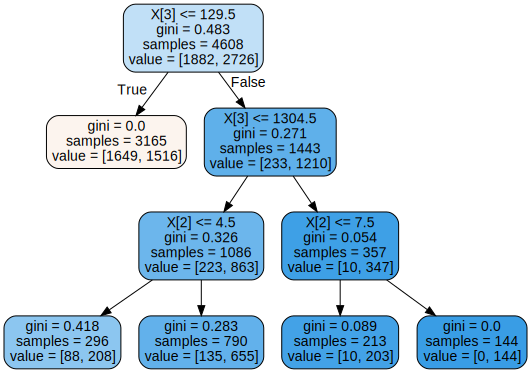

In [208]:

dot_data = export_graphviz(nurs_cm2.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [214]:
import pickle
pickle.dump(out, open('DTree/dtree_output.pkl', 'wb'))
#cms = pickle.load(open('DTree/cm_list.pkl', 'rb'))

In [241]:
for cm in cms:
    cm.regrets = cm.regrets[['split', 'leaf']]
    cm.y = cm.regrets.idxmin(axis=1)
    cm.retrain_model(C=0.05)

In [129]:
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, reps=1, y=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl)
    dt.model = dt.model.fit(dt.X, dt.y, dt.regrets, dt.C)
    return dt

In [199]:
def get_results(dbs, cm):
    dt = PDTree()
    if isinstance(cm, list):
        big_cm = combine_cms(cm, msl=10)
    else:
        big_cm = cm
    budgets = [x.epsilon for x in dbs]
    L = []
    for t in dbs:
        print('Start1')
        L.append( dt.fit_and_predict(t, null_cm()) )
    #Reset budgets
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L2 = []
    for t in dbs:
        print('Start2')
        L2.append(dt.fit_and_predict(t, big_cm))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L3 = []
    for t in dbs:
        fried_cm = FriedmanCM(t, tree_algs)
        print('Start3')
        L3.append(dt.fit_and_predict(t, fried_cm))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M2 = np.array([(L2[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M3 = np.array([(L3[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    return (L, M, L2, M2, L3, M3)

In [274]:
nurs_cm = out[0][0]

In [41]:
#Random features for nurs_cm
nurs_feat = nurs_cm.X.reset_index(drop=True)

In [43]:
nurs_feat = nurs_feat.apply(np.log)

In [63]:
nurs_feat.depth = np.exp(nurs_feat.depth).astype('int32')

In [106]:
nurs_feat.columns[10]

'special2'

In [115]:
nurs_feat['nrow_add_eps'] = nurs_feat.nrow + nurs_feat.eps
nurs_feat['nrow_sub_eps'] = nurs_feat.nrow - nurs_feat.eps
nurs_feat['special1'] = nurs_feat.nrow + nurs_feat.eps - nurs_feat.t - nurs_feat.C
nurs_feat['special2'] = nurs_feat.nrow + nurs_feat.eps - nurs_feat.t + nurs_feat.C
nurs_feat['special3'] = nurs_feat.nrow + nurs_feat.eps + nurs_feat.t - nurs_feat.C
nurs_feat['special4'] = nurs_feat.nrow + nurs_feat.eps + nurs_feat.t + nurs_feat.C
nurs_feat['special5'] = nurs_feat.nrow - nurs_feat.eps - nurs_feat.t - nurs_feat.C
nurs_feat['special6'] = nurs_feat.nrow - nurs_feat.eps - nurs_feat.t + nurs_feat.C
nurs_feat['special7'] = nurs_feat.nrow - nurs_feat.eps + nurs_feat.t - nurs_feat.C
nurs_feat['special8'] = nurs_feat.nrow - nurs_feat.eps + nurs_feat.t + nurs_feat.C
nurs_feat['special9'] = nurs_feat.nrow + nurs_feat.eps - nurs_feat.bf + nurs_feat.C

In [116]:
nurs_cm.X = nurs_feat
nurs_cm.regrets = nurs_cm.regrets.reset_index(drop=True)
nurs_cm.y = nurs_cm.y.reset_index(drop=True)

In [121]:
nurs_cm.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
nurs_cm.model.fit(nurs_cm.X, nurs_cm.y, nurs_cm.regrets, 0.02)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

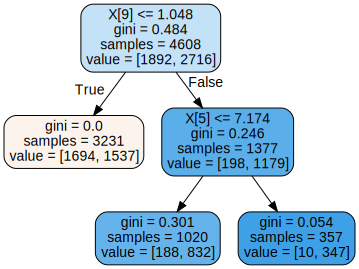

In [122]:
dot_data = export_graphviz(nurs_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [247]:
nurs_cm.X

,C,bf,depth,eps,ncol,nrow,t,nrow_add_eps,nrow_sub_eps,special1,special2,special3,special4,special5,special6,special7,special8,special9
0,1.609438,1.189584,1,-2.302585,1.945910,8.044947,1.609438,5.742362,10.347532,2.523486,5.742362,5.742362,8.961238,7.128656,10.347532,10.347532,13.566408,6.162216
1,1.609438,1.272966,1,-2.302585,1.945910,8.473241,1.609438,6.170656,10.775826,2.951780,6.170656,6.170656,9.389532,7.556951,10.775826,10.775826,13.994702,6.507128
2,1.609438,1.189584,1,-2.302585,1.945910,7.895063,1.609438,5.592478,10.197649,2.373603,5.592478,5.592478,8.811354,6.978773,10.197649,10.197649,13.416524,6.012332
3,1.609438,1.232144,1,-2.302585,1.945910,8.112528,1.609438,5.809943,10.415113,2.591067,5.809943,5.809943,9.028818,7.196237,10.415113,10.415113,13.633989,6.187237
4,1.609438,1.189584,1,-2.302585,1.945910,7.876638,1.609438,5.574053,10.179224,2.355178,5.574053,5.574053,8.792929,6.960348,10.179224,10.179224,13.398099,5.993907
5,1.609438,1.272966,1,-2.302585,1.945910,8.395477,1.609438,6.092892,10.698063,2.874017,6.092892,6.092892,9.311768,7.479187,10.698063,10.698063,13.916938,6.429365
6,1.609438,1.189584,1,-2.302585,1.945910,7.962416,1.609438,5.659831,10.265001,2.440955,5.659831,5.659831,8.878706,7.046125,10.265001,10.265001,13.483877,6.079684
7,1.609438,1.189584,1,-2.302585,1.945910,7.873217,1.609438,5.570632,10.175802,2.351756,5.570632,5.570632,8.789508,6.956926,10.175802,10.175802,13.394678,5.990486
8,1.609438,1.189584,1,-2.302585,1.945910,7.913887,1.609438,5.611302,10.216472,2.392426,5.611302,5.611302,8.830177,6.997596,10.216472,10.216472,13.435348,6.031155
9,1.609438,1.232144,1,-2.302585,1.945910,8.366835,1.609438,6.064250,10.669420,2.845374,6.064250,6.064250,9.283126,7.450545,10.669420,10.669420,13.888296,6.441544


In [253]:
pickle.dump(nurs_cm, open('DTree/nurs_cm.pkl', 'wb'))

In [124]:
np.exp(1.048)

2.8519415273209767

In [273]:
pd.value_counts(nurs_cm.y)

leaf     3105
split    1503
dtype: int64

In [272]:
pd.value_counts(nurs_cm2.y)

split    2726
leaf     1882
dtype: int64

In [282]:
nurs_feat

,depth,eps,ncol,nrow,log_eps,log_ncol,log_nrow,eps_add_nrow,eps_sub_nrow
0,1,0.1,7,3118,-2.302585,1.945910,8.044947,9.990857,6.099037
1,1,0.1,7,4785,-2.302585,1.945910,8.473241,10.419151,6.527331
2,1,0.1,7,2684,-2.302585,1.945910,7.895063,9.840974,5.949153
3,1,0.1,7,3336,-2.302585,1.945910,8.112528,10.058438,6.166618
4,1,0.1,7,2635,-2.302585,1.945910,7.876638,9.822549,5.930728
5,1,0.1,7,4427,-2.302585,1.945910,8.395477,10.341388,6.449567
6,1,0.1,7,2871,-2.302585,1.945910,7.962416,9.908326,6.016506
7,1,0.1,7,2626,-2.302585,1.945910,7.873217,9.819127,5.927307
8,1,0.1,7,2735,-2.302585,1.945910,7.913887,9.859797,5.967977
9,1,0.1,7,4302,-2.302585,1.945910,8.366835,10.312745,6.420925


In [127]:
def get_results2(dbs):
    dt = PDTree()
    budgets = [x.epsilon for x in dbs]
    L = []
    for t in dbs:
        print('Start1')
        L.append( dt.fit_and_predict(t, null_cm()) )
    #Reset budgets
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L2 = []
    for t in dbs:
        print('Start2')
        fried_cm = FriedmanCM(t, tree_algs)
        L2.append(dt.fit_and_predict(t, fried_cm))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L3 = []
    for t in dbs:
        print('Start3')
        fried_cm = FriedmanCM(t, tree_algs, 2.852)
        L3.append(dt.fit_and_predict(t, fried_cm))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M2 = np.array([(L2[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M3 = np.array([(L3[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    return (L, M, L2, M2, L3, M3)

In [131]:
results0 = get_results2(data_train[2])

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [132]:
results0[1].mean()

0.70882420138132918

In [133]:
results0[3].mean()

0.90277570312405275

In [134]:
results0[5].mean()

0.90239995276315932

In [135]:
results1 = get_results2(data_train[1])

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [137]:
results1[1].mean()
results1[3].mean()


0.77874332387966239

In [138]:
results1[5].mean()

0.7938232684930806

In [139]:
results3 = get_results2(data_train[3])

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [205]:
pickle.dump([results0, results1, results3], open('DTree/results.pkl', 'wb'))

In [179]:
alg1_error = 1-np.concatenate([results0[1], results1[1], results3[1]])

In [180]:
alg2_error = 1-np.concatenate([results0[3], results1[3], results3[3]])

In [181]:
alg3_error = 1-np.concatenate([results0[5], results1[5], results3[5]])

In [188]:
best = np.min([alg1_error, alg2_error, alg3_error], axis=0)

In [193]:
avg_regret1 = (alg1_error-best).reshape((3,-1)).mean(axis=0)
avg_regret2 = (alg2_error-best).reshape((3,-1)).mean(axis=0)
avg_regret3 = (alg3_error-best).reshape((3,-1)).mean(axis=0)

In [195]:
#Now average out over the different databases
avg_regret1 = avg_regret1.reshape((3,3)).mean(axis=0)

In [196]:
avg_regret2 = avg_regret2.reshape((3,3)).mean(axis=0)

In [197]:
avg_regret3 = avg_regret3.reshape((3,3)).mean(axis=0)

In [201]:
juxtaposed_alg_perfs = np.array([avg_regret1, avg_regret2, avg_regret3]).T.flatten()

In [202]:
x_pos = np.array([4*x + y for x in [0,1,2] for y in [0,1,2]])

In [220]:
x_pos

array([ 0,  1,  2,  4,  5,  6,  8,  9, 10])

In [210]:
colors = ['red', 'blue', 'green']*3

In [242]:
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c) for c in ['red', 'blue', 'green']]

<Container object of 9 artists>

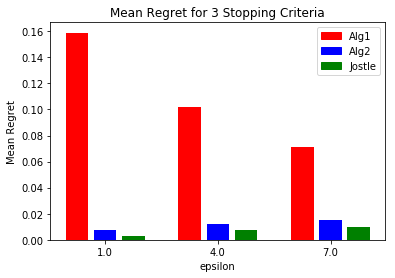

In [245]:
fig, axis = plt.subplots()
axis.set_xticks([1,5,9])
axis.set_xticklabels(['1.0', '4.0', '7.0'])
axis.set_xlabel('epsilon')
axis.set_ylabel('Mean Regret')
axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Regret for 3 Stopping Criteria')
axis.bar(x_pos, juxtaposed_alg_perfs, color=colors)